# Классификация методом kNN (k ближайших соседей)

## Описание задачи и информация о датасете
Маммография - самый эффективный метод диагностики рака груди, который доступен сегодня. Компьютерная диагностика (CAD) для характеристики маммографических образований как злокачественных или доброкачественных может помочь радиологам снизить частоту биопсии без увеличения количества ложноотрицательных результатов. Датасет содержит оценку BI-RADS, возраст пациента и три атрибута BI-RADS, вместе с  ground truth (severity) для доброкачественных и злокачественных новообразований, которые были идентифицированы на полноформатных цифровых маммограммах, собранных в университете Эрлангена — Нюрнберга с 2003 по 2006 год. Каждому экземпляру соответствует оценка BI-RADS в диапазоне от 1 (определенно безвредно) до 5 (что свидетельствует о злокачественности), которые были присвоены в процессе двойного обзора врачей.  Датасет можно использовать для прогнозирования степени тяжести образований (доброкачественная или злокачественная) на основе атрибутов, описывающих особенности образований, и возраста пациента.\
Распределение по классам: доброкачественные = 516, злокачественные = 445. \
Информация об атрибутах: всего 6 атрибутов (1 goal field, 1 непрогнозируемый, 4 прогнозируемых атрибута):\
BI-RADS assessment: от 1 до 5 (порядковый, непрогнозируемый!); Age: возраст пациента в годах (целочисленный); Shape: форма образований: круглая = 1, овальная, = 2 дольчатая = 3, неправильная = 4 (номинальный); Margin: края образований: ограниченные = 1, микролобулированные = 2, затемненные = 3, нечеткие = 4, спикулированные = 5(номинальный); Density: плотность образований: высокая = 1, изоплотность = 2, низкая = 3, жиросодержащая = 4 (порядковый); Severity: степень тяжести: доброкачественная = 0 или злокачественная = 1 (биноминальная, goal field!).\
Пропущенные значения:
BI-RADS assessment: 2; Age: 5; Shape: 31; Margin: 48; Density: 76; Severity: 0.\
Ссылка на датасет: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Загрузка и прочтение данных

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data'
data = pd.read_csv(url)

In [3]:
data.shape

(960, 6)

In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
data

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0
...,...,...,...,...,...,...
955,4,47,2,1,3,0
956,4,56,4,5,3,1
957,4,64,4,5,3,0
958,5,66,4,5,3,1


In [6]:
data.columns = ['BIRADS_assessment', 'Age', 'Shape', 'Margin', 'Density', 'Severity']

## Визуализация данных и описательная статистика

In [7]:
data.dtypes

BIRADS_assessment    object
Age                  object
Shape                object
Margin               object
Density              object
Severity              int64
dtype: object

In [8]:
data.head()

,BIRADS_assessment,Age,Shape,Margin,Density,Severity
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


Для количественных признаков приведены количество значений, средние значения, стандартное отклонение, минимальное и макимальное значения, медиана и значения квартилей:

In [9]:
data.describe()

,Severity
count,960.000000
mean,0.462500
std,0.498852
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Для признаков типа object приведены количество значений, количество уникальных значений, самое распространенные значение и частота наиболее распространенного значения:

In [10]:
data.describe(include = ['object'])

,BIRADS_assessment,Age,Shape,Margin,Density
count,960,960,960,960,960
unique,8,74,5,6,5
top,4,59,4,1,3
freq,547,36,400,357,797


Диаграммы, которые показывают сколько раз номинальные признаки принимают те или иные значения:

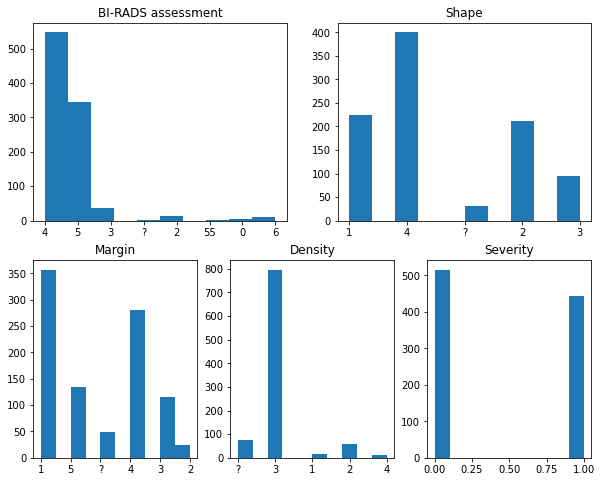

In [11]:
fig = plt.figure(figsize = (10, 8))
ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)
ax_3 = fig.add_subplot(2, 3, 4)
ax_4 = fig.add_subplot(2, 3, 5)
ax_5 = fig.add_subplot(2, 3, 6)
ax_1.hist(data.loc[:, "BIRADS_assessment"])
ax_1.set_title('BI-RADS assessment')
ax_2.hist(data.loc[:, "Shape"])
ax_2.set_title('Shape')
ax_3.hist(data.loc[:, "Margin"])
ax_3.set_title('Margin')
ax_4.hist(data.loc[:, "Density"])
ax_4.set_title('Density')
ax_5.hist(data.loc[:, "Severity"])
ax_5.set_title('Severity')
plt.show()

Диаграмма, которая показывает сколько пациентов того или иного возраста:

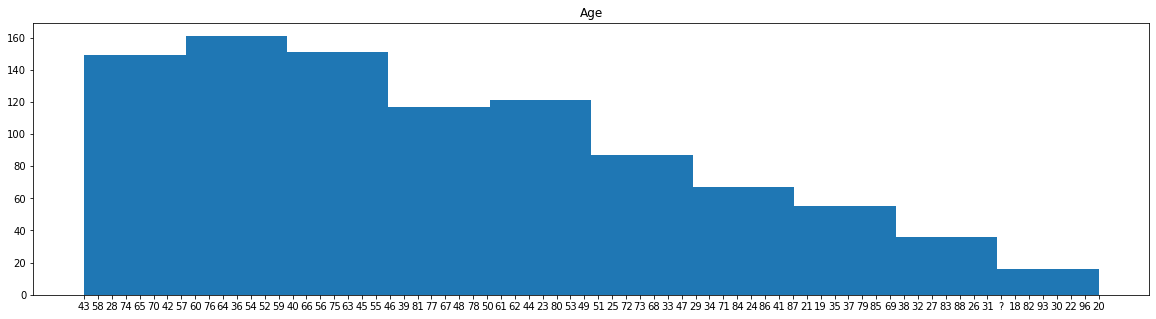

In [12]:
fig = plt.figure(figsize = (20, 5))
plt.hist(data.loc[:, "Age"])
plt.title('Age')
plt.show()

На основе диаграммы можно сделать вывод о том, что большинство пациентов имеет средний/пожилой возраст. Меньшинство имеет молодой или старческий возраст.

## Обработка пропущенных значений

Атрибут BI-RADS assessment непрогнозируемый, поэтому его можно исключить.

In [13]:
data = data.drop(['BIRADS_assessment'], axis=1)

In [14]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']

In [15]:
data.loc[data.Shape == "?", 'Shape'] = None
data.loc[data.Age == "?", 'Age'] = None
data.loc[data.Margin == "?", 'Margin'] = None
data.loc[data.Density == "?", 'Density'] = None

In [16]:
data.head()

,Age,Shape,Margin,Density,Severity
0,43,1,1,None,1
1,58,4,5,3,1
2,28,1,1,3,0
3,74,1,5,None,1
4,65,1,None,3,0


In [17]:
data['Shape'].unique()

array(['1', '4', None, '2', '3'], dtype=object)

In [18]:
data['Shape'].describe().top

'4'

In [19]:
data['Shape'] = data['Shape'].fillna('4')

In [20]:
data['Shape'].unique()

array(['1', '4', '2', '3'], dtype=object)

Для категориальных признаков пропущенные значения заполняем самым популярным значением в столбце (у признака Severity нет пропущенных значений, поэтому его не трогаем):

In [21]:
data_describe = data.describe(include = [object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])

In [22]:
data.head()

,Age,Shape,Margin,Density,Severity
0,43,1,1,3,1
1,58,4,5,3,1
2,28,1,1,3,0
3,74,1,5,3,1
4,65,1,1,3,0


## Бинаризация номинальных признаков

In [23]:
nonbinary_columns = ['Shape', 'Margin', 'Density']
binary_columns = ['Severity']

In [24]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['Shape_1', 'Shape_2', 'Shape_3', 'Shape_4', 'Margin_1', 'Margin_2',
       'Margin_3', 'Margin_4', 'Margin_5', 'Density_1', 'Density_2',
       'Density_3', 'Density_4'],
      dtype='object')


## Нормализация

Атрибут Age является целочисленным, т.е количественным, поэтому приводим его к целочисленному типу и выполняем стандратизацию:

In [25]:
data_age = data['Age'].astype('int64')

In [26]:
data_age = (data_age - data_age.mean(axis = 0))/data_age.std(axis = 0)

In [27]:
data_age.describe()

count    9.600000e+02
mean     8.529057e-17
std      1.000000e+00
min     -2.595200e+00
25%     -7.263446e-01
50%      1.042579e-01
75%      7.272098e-01
max      2.803716e+00
Name: Age, dtype: float64

Соединяем все в одну таблицу:

In [28]:
data = pd.concat((data_age, data_nonbinary, data[binary_columns]), axis = 1)

In [29]:
data.describe()

,Age,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5,Density_1,Density_2,Density_3,Density_4,Severity
count,9.600000e+02,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.00000,960.000000
mean,8.529057e-17,0.233333,0.219792,0.097917,0.448958,0.421875,0.025000,0.120833,0.291667,0.140625,0.016667,0.061458,0.909375,0.01250,0.462500
std,1.000000e+00,0.423173,0.414321,0.297357,0.497647,0.494116,0.156206,0.326103,0.454767,0.347816,0.128086,0.240294,0.287225,0.11116,0.498852
min,-2.595200e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,-7.263446e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
50%,1.042579e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
75%,7.272098e-01,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,1.000000
max,2.803716e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


Теперь можно построить корреляционную матрицу:

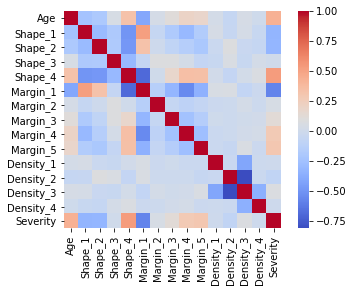

In [30]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

По изображению видно, что признаки практически не коррелируют между собой, так как являются независимыми.

## Разбиение данных на обучающуюю и тестовую выборки

Для предсказания будем использовать все входные признаки, кроме Severity, так как он является нашим goal field.

In [31]:
x = np.array(data.drop(['Severity'], axis=1))
y = np.array(data['Severity'])

In [32]:
print(x.shape)
print(y.shape)
N, d = x.shape

(960, 14)
(960,)


Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

720 240


## Классификация

### Метод kNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [35]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)

In [36]:
err_test

0.21666666666666667

Подбор параметров для уменьшения ошибки:

In [37]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.18888888888888888 35


#### Вычисление ошибки на обучающей и тестовой выборках

In [38]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print(err_train, err_test)

0.18194444444444444 0.21666666666666667


##### Вывод:

Метод k ближайших соседей довольно неплохо справился со своей задачей, так как процент правильно предсказанных значений составляет ~80% на обучающей выборке и ~76% на тестовой выборке. Для данного датасета среднее число ближайших соседей оказалось наиболее оптимальным.

### Метод Random Forest

In [39]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print(err_train, err_test)

0.09444444444444444 0.23333333333333334


##### Сравнение результатов:

Метод Random Forest даёт значение ошибки на тестовой выборке практически в 2 раза меньше, чем метод kNN, а вот на тестовой выборке разница не такая значительная, но kNN даёт значение ошибки меньше. В целом Random Forest показывает себя лучше, чем kNN.

## Выводы:

В данной работе было выполнено: визуализация данных, вычисление основных характеристик, обработка пропущенных значений и номинальных признаков, нормализация количественных признаков, разбиение данных на обучающую и тестовую выборки, применение алгоритмов классификации к обработанному набору данных. На основе проделанной работы можно сделать вывод о том, что использование классификации образований и включение более подробных атрибутов для их описания может улучшить прогнозы и предоставить более надежную модель для определения степени тяжести новообразования в будущем.